#### Make sure you already install pcl

You can look at here how to install pcl for your OS, https://github.com/strawlab/python-pcl#installation

In [1]:
# !git clone https://github.com/klintan/pypcd.git
# !cd pypcd
# !python3 setup.py install
# pip3 install python-pcl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pypcd import pypcd
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import pcl
import glob

In [3]:
# !unzip data_1.zip

In [4]:
pcds = glob.glob('data_1/*.pcd')
pcds.sort()
pcds

['data_1/0000000000.pcd',
 'data_1/0000000001.pcd',
 'data_1/0000000002.pcd',
 'data_1/0000000003.pcd',
 'data_1/0000000004.pcd',
 'data_1/0000000005.pcd',
 'data_1/0000000006.pcd',
 'data_1/0000000007.pcd',
 'data_1/0000000008.pcd',
 'data_1/0000000009.pcd',
 'data_1/0000000010.pcd',
 'data_1/0000000011.pcd',
 'data_1/0000000012.pcd',
 'data_1/0000000013.pcd',
 'data_1/0000000014.pcd',
 'data_1/0000000015.pcd',
 'data_1/0000000016.pcd',
 'data_1/0000000017.pcd',
 'data_1/0000000018.pcd',
 'data_1/0000000019.pcd',
 'data_1/0000000020.pcd',
 'data_1/0000000021.pcd']

In [5]:
pc = pypcd.PointCloud.from_path(pcds[0])
pc

In [6]:
pc.pc_data

array([(52.301,  7.3  ,  1.995, 0.12), (50.572,  7.22 ,  1.937, 0.  ),
       (48.788,  7.277,  1.877, 0.  ), ...,
       ( 3.592, -1.338, -1.671, 0.  ), ( 3.756, -1.387, -1.751, 0.  ),
       ( 0.   ,  0.   ,  0.   , 0.  )],
      dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('intensity', '<f4')])

#### Filteration based on here, https://github.com/vidit0210/SFND_Lidar_Obstacle_Detection/blob/master/src/environment.cpp#L116

In [7]:
x = pc.pc_data['x'][(pc.pc_data['x'] > -10) & (pc.pc_data['x'] < 40) \
                    & (pc.pc_data['y'] > -6) & (pc.pc_data['x'] < 8) &\
                   (pc.pc_data['z'] > -2) & (pc.pc_data['z'] < 2)]
y = pc.pc_data['y'][(pc.pc_data['x'] > -10) & (pc.pc_data['x'] < 40) \
                    & (pc.pc_data['y'] > -6) & (pc.pc_data['x'] < 8) &\
                   (pc.pc_data['z'] > -2) & (pc.pc_data['z'] < 2)]
z = pc.pc_data['z'][(pc.pc_data['x'] > -10) & (pc.pc_data['x'] < 40) \
                    & (pc.pc_data['y'] > -6) & (pc.pc_data['x'] < 8) &\
                   (pc.pc_data['z'] > -2) & (pc.pc_data['z'] < 2)]
x.shape, y.shape, z.shape

((63417,), (63417,), (63417,))

In [8]:
p = pcl.PointCloud(np.array([x, y, z]).T)
sor = p.make_voxel_grid_filter()
sor.set_leaf_size(0.2, 0.2, 0.2)
cloud_filtered = sor.filter()
cloud_filtered = np.asarray(cloud_filtered)
cloud_filtered.shape

(8701, 3)

In [9]:
cloud = pcl.PointCloud(cloud_filtered)
seg = cloud.make_segmenter_normals(ksearch=10)
seg.set_optimize_coefficients(True)
seg.set_model_type(pcl.SACMODEL_PLANE)
seg.set_method_type(pcl.SAC_RANSAC)
seg.set_distance_threshold(0.25)
seg.set_max_iterations(100)
indices, coefficients = seg.segment()
plane = np.array(cloud)[indices]
plane.shape

(4027, 3)

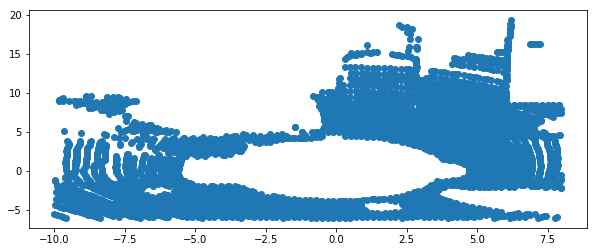

In [10]:
plt.figure(figsize = (10, 4))
plt.scatter(plane[:,0], plane[:, 1])
plt.show()

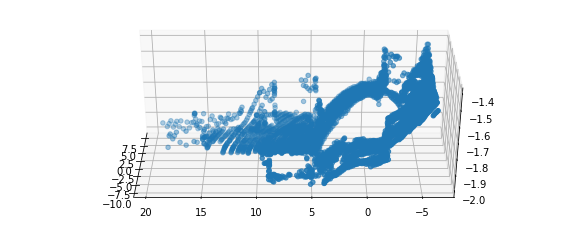

In [11]:
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plane[:,0], plane[:, 1], plane[:, 2])
ax.view_init(30, 180)
plt.show()

#### Dynamic plot

If you want dynamically draw pcd data,
```
pip3 install ipyvolume
```

In [12]:
import ipyvolume as ipv
import numpy as np
ipv.quickscatter(cloud_filtered[:,0], cloud_filtered[:, 1], cloud_filtered[:, 2], size=1)

In [13]:
p = pcl.PointCloud(plane)
tree = p.make_kdtree()
ec = p.make_EuclideanClusterExtraction()
ec.set_ClusterTolerance(0.5)
ec.set_MinClusterSize(10)
ec.set_MaxClusterSize(1000)
ec.set_SearchMethod(tree)
cluster_indices = ec.Extract()

In [14]:
clusters, inners = [], []
for j, indices in enumerate(cluster_indices):
    inner = []
    for i, indice in enumerate(indices):
        c = [p[indice][0],
             p[indice][1],
             p[indice][2]]
        clusters.append(c)
        inner.append(c)
    inners.append(inner)
len(clusters)

74

In [15]:
clusters = np.array(clusters)
clusters.shape

(74, 3)

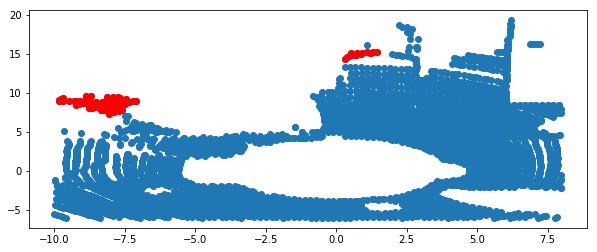

In [16]:
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(111)
plt.scatter(plane[:,0], plane[:, 1])
plt.scatter(clusters[:,0], clusters[:, 1], c = 'r')
plt.show()

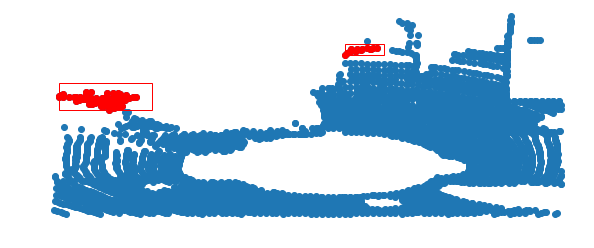

In [17]:
import matplotlib.patches as patches

fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(111)
ax.scatter(plane[:,0], plane[:, 1])
ax.scatter(clusters[:,0], clusters[:, 1], c = 'r')

for ins in inners:
    ins = np.array(ins)
    w = ins[:,0].max() - ins[:,0].min()
    h = ins[:,1].max() - ins[:,1].min()
    lx = ins[:,0].min()
    ly = ins[:,1].min()
    rect = patches.Rectangle((lx, ly),
                             w + w * 0.2,
                             h + h * 0.5, 
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.axis('off')
plt.show()

In [18]:
def save_png(pc):
    path = pc
    pc = pypcd.PointCloud.from_path(pc)
    x = pc.pc_data['x'][(pc.pc_data['x'] > -10) & (pc.pc_data['x'] < 40) \
                    & (pc.pc_data['y'] > -6) & (pc.pc_data['x'] < 8) &\
                   (pc.pc_data['z'] > -2) & (pc.pc_data['z'] < 2)]
    y = pc.pc_data['y'][(pc.pc_data['x'] > -10) & (pc.pc_data['x'] < 40) \
                        & (pc.pc_data['y'] > -6) & (pc.pc_data['x'] < 8) &\
                       (pc.pc_data['z'] > -2) & (pc.pc_data['z'] < 2)]
    z = pc.pc_data['z'][(pc.pc_data['x'] > -10) & (pc.pc_data['x'] < 40) \
                        & (pc.pc_data['y'] > -6) & (pc.pc_data['x'] < 8) &\
                       (pc.pc_data['z'] > -2) & (pc.pc_data['z'] < 2)]
    p = pcl.PointCloud(np.array([x, y, z]).T)
    sor = p.make_voxel_grid_filter()
    sor.set_leaf_size(0.2, 0.2, 0.2)
    cloud_filtered = sor.filter()
    cloud_filtered = np.asarray(cloud_filtered)
    cloud = pcl.PointCloud(cloud_filtered)
    seg = cloud.make_segmenter_normals(ksearch=10)
    seg.set_optimize_coefficients(True)
    seg.set_model_type(pcl.SACMODEL_PLANE)
    seg.set_method_type(pcl.SAC_RANSAC)
    seg.set_distance_threshold(0.25)
    seg.set_max_iterations(100)
    indices, coefficients = seg.segment()
    plane = np.array(cloud)[indices]
    p = pcl.PointCloud(plane)
    tree = p.make_kdtree()
    ec = p.make_EuclideanClusterExtraction()
    ec.set_ClusterTolerance(0.5)
    ec.set_MinClusterSize(10)
    ec.set_MaxClusterSize(1000)
    ec.set_SearchMethod(tree)
    cluster_indices = ec.Extract()
    clusters, inners = [], []
    for j, indices in enumerate(cluster_indices):
        inner = []
        for i, indice in enumerate(indices):
            c = [p[indice][0],
                 p[indice][1],
                 p[indice][2]]
            clusters.append(c)
            inner.append(c)
        inners.append(inner)
    clusters = np.array(clusters)
    fig = plt.figure(figsize = (10, 4))
    ax = fig.add_subplot(111)
    ax.scatter(plane[:,0], plane[:, 1])
    ax.scatter(clusters[:,0], clusters[:, 1], c = 'r')

    for ins in inners:
        ins = np.array(ins)
        w = ins[:,0].max() - ins[:,0].min()
        h = ins[:,1].max() - ins[:,1].min()
        lx = ins[:,0].min()
        ly = ins[:,1].min()
        rect = patches.Rectangle((lx, ly),
                                 w + w * 0.2,
                                 h + h * 0.5, 
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    fig.savefig('output/%s.png'%(path.split('/')[1]))

In [19]:
# !mkdir output

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


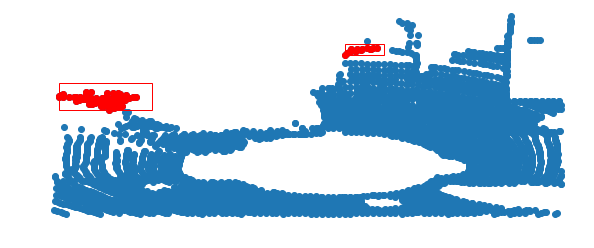

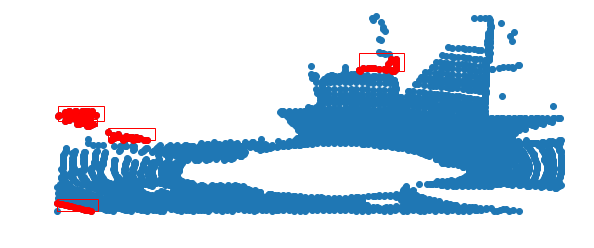

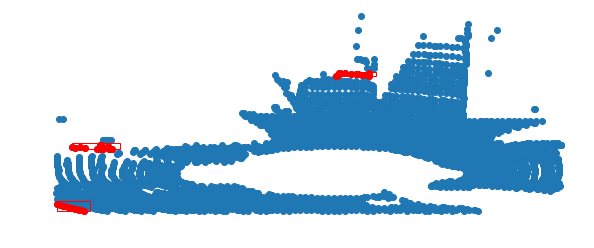

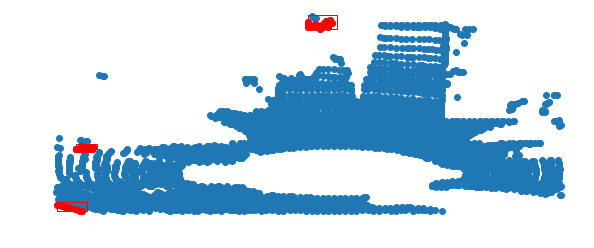

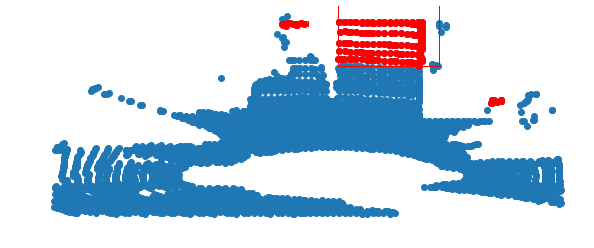

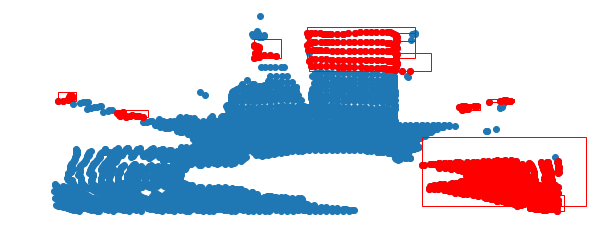

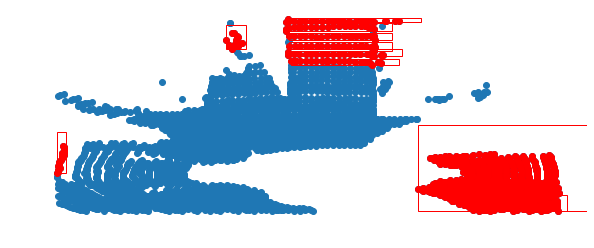

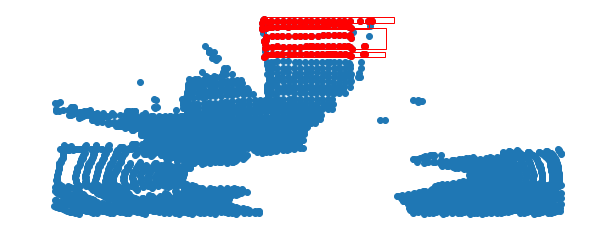

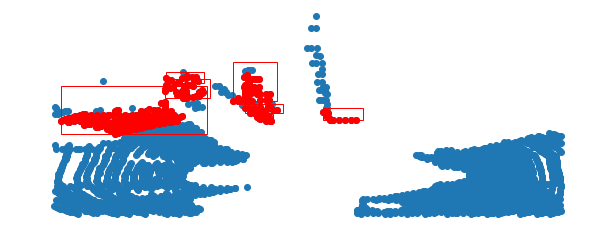

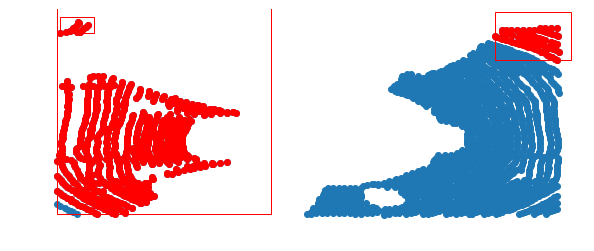

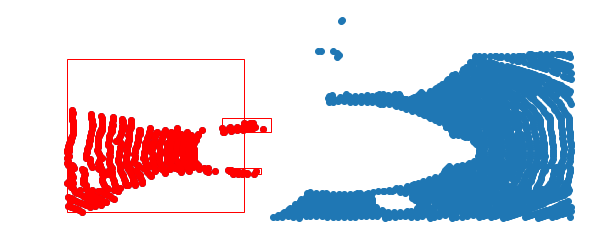

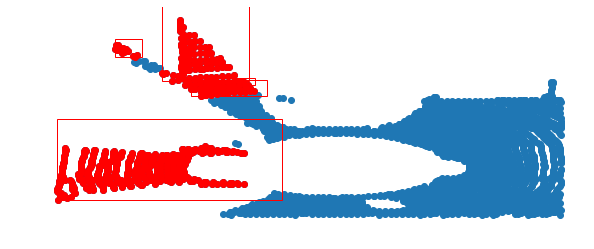

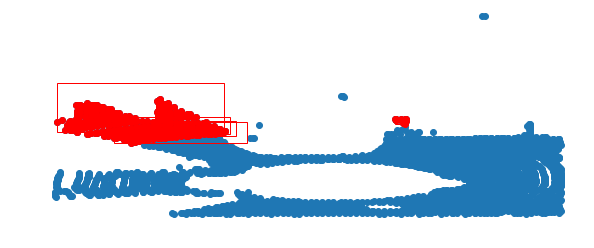

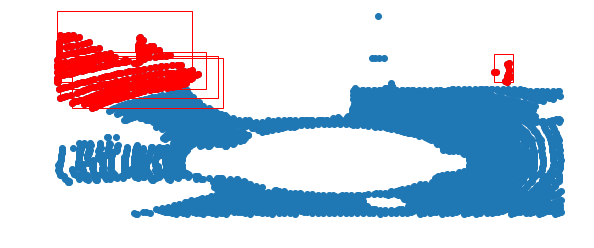

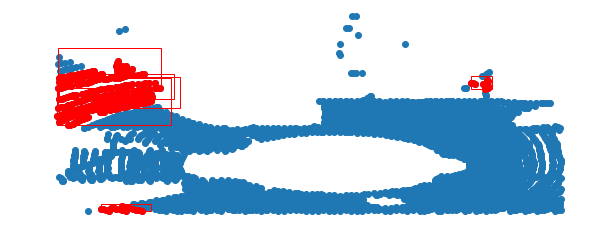

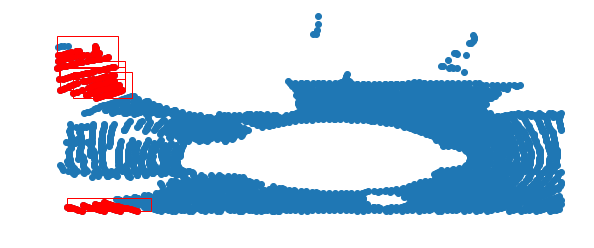

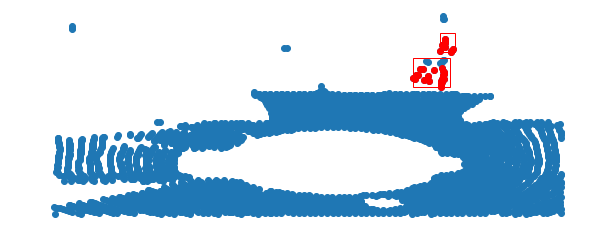

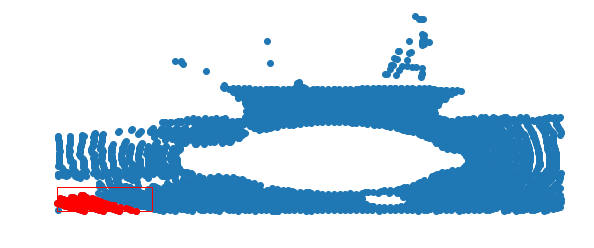

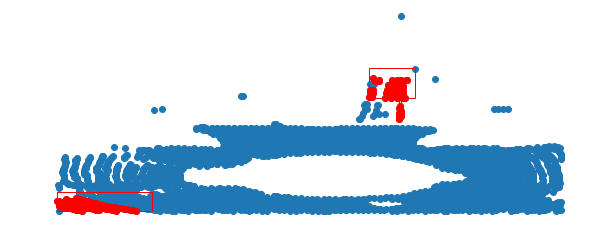

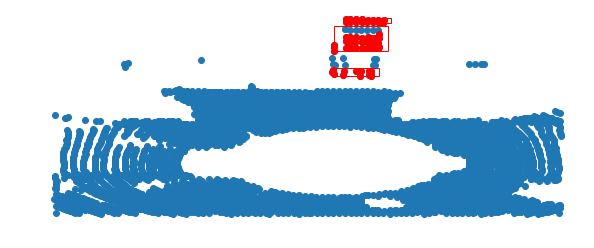

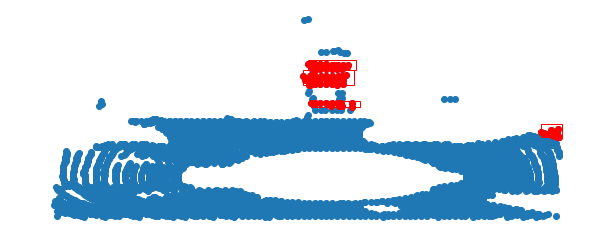

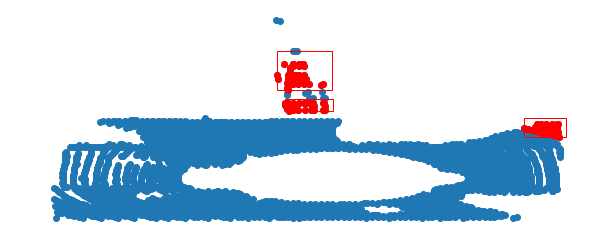

In [20]:
for pcd in pcds:
    save_png(pcd)

In [23]:
# !pip3 install imageio

In [22]:
import imageio
images = []
for filename in glob.glob('output/*.png'):
    images.append(imageio.imread(filename))
imageio.mimsave('output.gif', images)